# Generating Images using Generative Adversarial Networks

**excellent repository of PyTorch tutorials:** https://github.com/yunjey/pytorch-tutorial

**Advanced GANs - Exploring Normalization Techniques for GAN training: Self-Attention and Spectral Norm:** https://sthalles.github.io/advanced_gans/

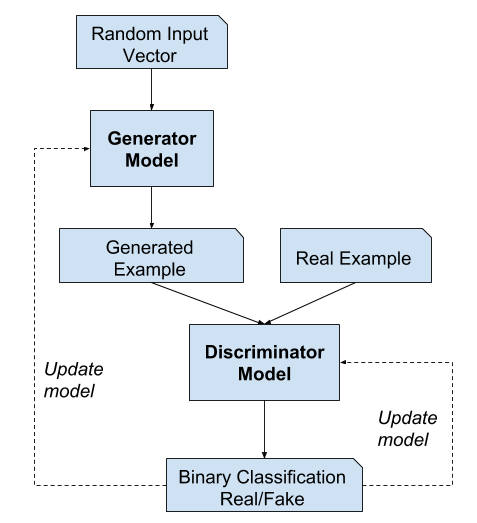

- Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat.
- GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization.
- we don't change the weights of the generator model while training the discriminator 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Load the Data

In [109]:
from torchvision.datasets import MNIST
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader

train_transforms = tt.Compose(
    [
        tt.ToTensor(),
        
        # Normalize a tensor image ,this transform does not support PIL Image.
        tt.Normalize([0.5,], [0.5,], inplace=True)
    ]
)

dataset = MNIST(root='data/', train=True, transform=train_transforms)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

## 2. Plot images

In [17]:
image, label = dataset[0]

print('Label:', label)

print(image.shape)
print(torch.max(image))
print(torch.min(image))

Label: 5
torch.Size([1, 28, 28])
tensor(1.)
tensor(-1.)


In [14]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

image_origine = denorm(image)
print(image_origine.shape)
print(torch.max(image_origine))
print(torch.min(image_origine))

torch.Size([1, 28, 28])
tensor(1.)
tensor(0.)


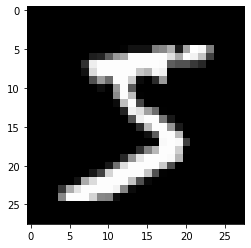

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image_origine[0], cmap='gray')

## 3. Discriminator Network

- **We'll use a simple feedforward network,** but we can also use a CNN for the discriminator.


- **We use the Leaky ReLU activation for the discriminator** : Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." 

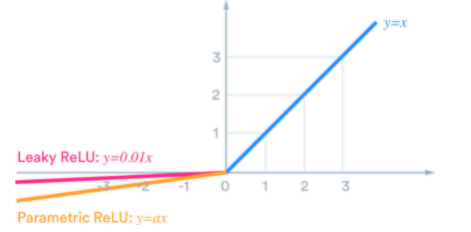

- **Sigmoid()**: Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real.

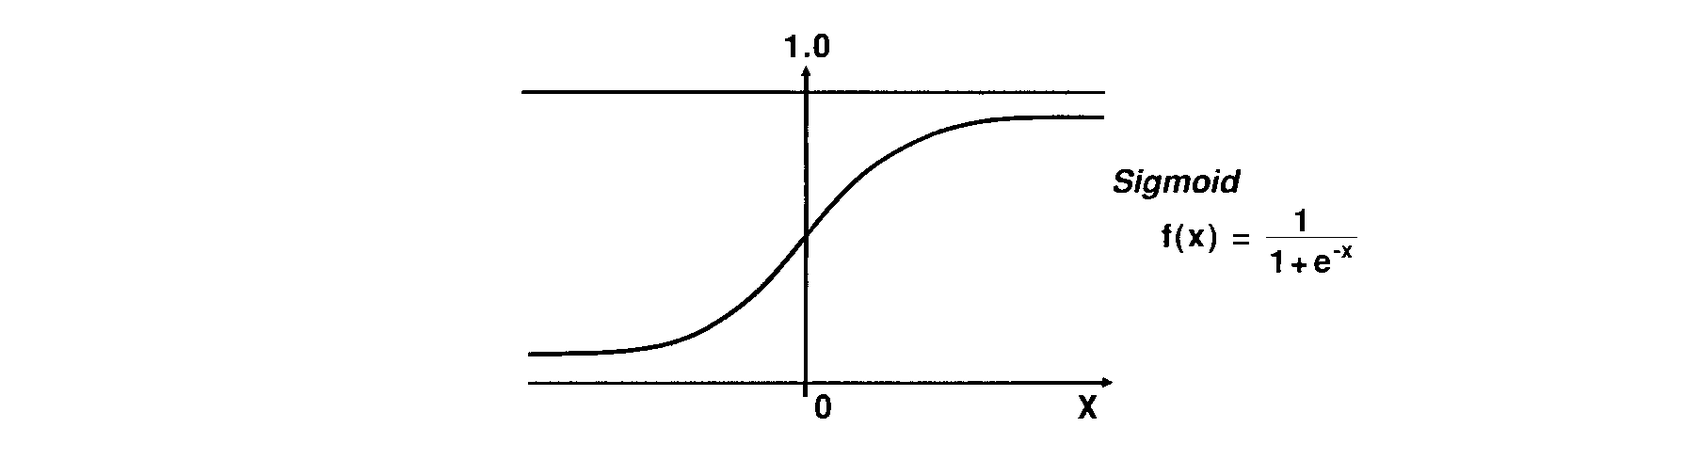

In [110]:
D = nn.Sequential(
    
    nn.Linear(in_features=28*28, out_features=256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

## 4. Generator Network

- **Neural Network**: To keep things simple, we'll use a feedfoward neural network with 3 layers, 


- **Input**: The input to the generator is typically a vector or a matrix which is used as a seed for generating an image.


- **Output**: The output will be a vector of size 784, which can be transformed to a 28x28 px image.


- **TanH()**: We use the TanH activation function for the output layer of the generator. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution.

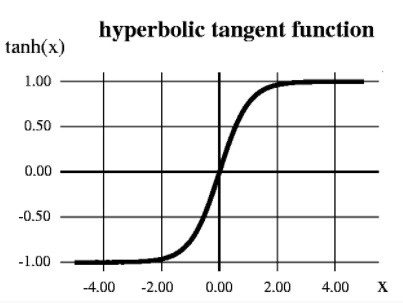

In [111]:
G = nn.Sequential(
    
    nn.Linear(in_features=64, out_features=256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 28*28),
    nn.Tanh()
)

### Generate an image

Note that since the outputs of the TanH activation lie in the range [-1,1], we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [31]:
v = torch.randn(2, 64)
v.shape

torch.Size([2, 64])

In [36]:
image_g = G(v)
image_g = image_g.reshape(2, 28, 28)
image_g.shape

torch.Size([2, 28, 28])

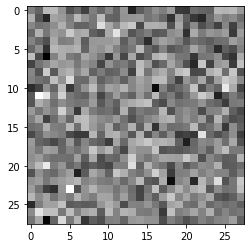

In [39]:
image_gen = denorm(image_g)
plt.imshow(image_gen[0].detach(), cmap='gray')

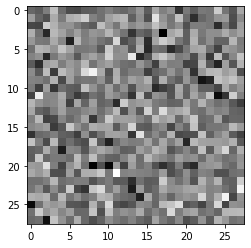

In [42]:
image_gen = denorm(image_g)
plt.imshow(image_gen[1].detach(), cmap='gray')

### Directory where we can save intermediate outputs

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [53]:
import os

sample_dir = 'data/samples_gan'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

In [57]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break
    

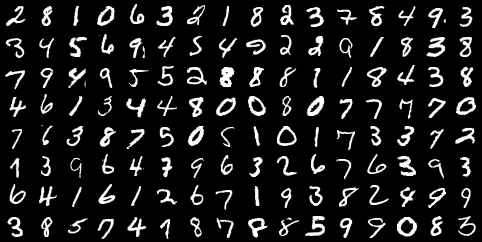

In [58]:
Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

In [59]:
sample_vectors = torch.randn(batch_size, 64)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)


Saving fake_images-0000.png


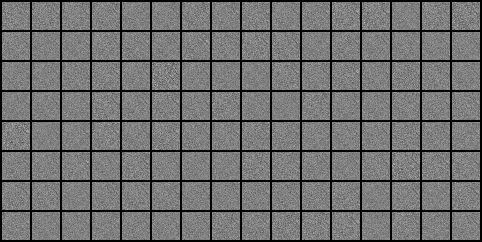

In [60]:
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## 5. Training

#### Binary cross entropy loss function

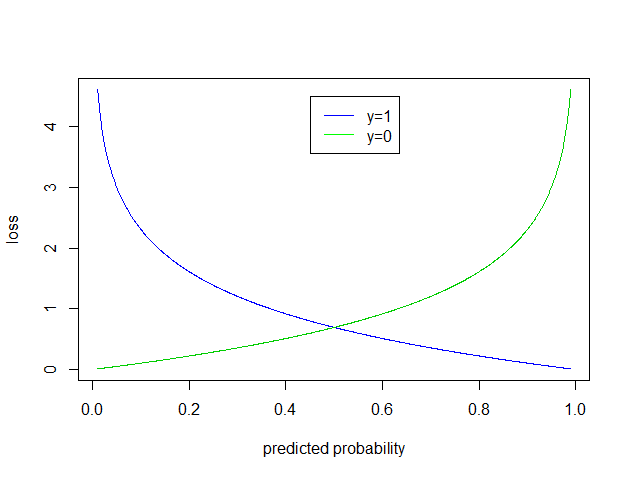
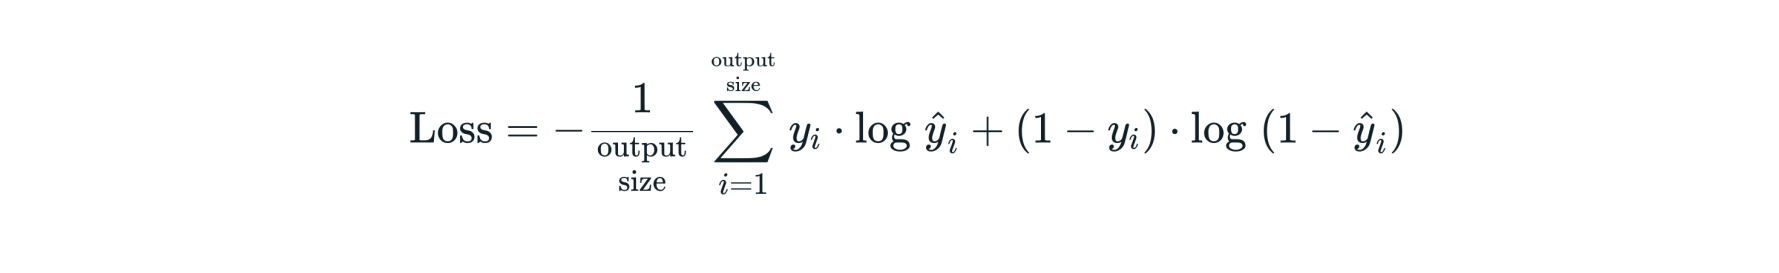

In [120]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

### 5.1. Discriminator Training

In [122]:
# One step of Gradient Descent on batch of real images and fake images.

def fit_discriminator(G, D, images, criterion):
    
    batch_size = images.shape[0]
    
    # Step1: Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
       
        
    # Step2: Loss for real and fake images
    outputs = D(images)
    loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    z = torch.randn(batch_size, 64)
    fake_images = G(z)
    outputs = D(fake_images)
    loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    
    # Step3: Combine losses
    loss = loss_real + loss_fake
    
    
    # Step4: Backprop and optimize
    reset_grad()
    loss.backward()
    d_optimizer.step()
    
    return loss, real_score, fake_score

### 5.2. Generator Training

In [123]:
# One step of Gradient Descent on batch of fake images.

def fit_generator(G, D, criterion, batch_size):
    
    # Step1: Generate fake images
    labels = torch.ones(batch_size, 1)
    z = torch.randn(batch_size, 64)
    fake_images = G(z)
    
    # Step2: Calculate loss
    output = D(fake_images)
    loss = criterion(output, labels)

    # Backprop and optimize
    reset_grad()
    loss.backward()
    g_optimizer.step()
    
    return loss, fake_images

### 5.3. Training the Model

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [139]:
def fit(G, D, train_loader, criterion, epochs=1):
    
    for epoch in range(epochs):
        for i, (images, _) in enumerate(train_loader):
            
            batch_size = images.shape[0]
        
            # Load a batch & transform to vectors :    [128, 1, 28, 28] -> [128, 784]
            images = images.reshape(batch_size, -1)
        
            # Train the discriminator and generator
            d_loss, real_score, fake_score = fit_discriminator(G, D, images, criterion)
            g_loss, fake_images = fit_generator(G, D, criterion, batch_size=batch_size)
        
            # Inspect the losses
            if i % 100 == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
            
                print('epoch {}/{}'.format(epoch+1, epochs), end=' , ')
                print('batch {}/{}'.format(i+1, len(train_loader)), end=' : ')
                print('d_loss = {:.8f}, g_loss = {:.8f}'.format(d_loss.item(), g_loss.item()), end=' ; ')
                print('D(x) = {:.2f}, D(G(z)) = {:.2f}'.format(real_score.mean().item(), fake_score.mean().item()))
        
        # Sample and save images
        save_fake_images(epoch+52)

In [125]:
criterion = torch.nn.MSELoss()

d_losses, g_losses, real_scores, fake_scores = [], [], [], []

In [140]:
%%time
fit(G, D, train_loader, criterion, epochs=9)

epoch 1/9 , batch 1/469 : d_loss = 0.13920480, g_loss = 0.82957727 ; D(x) = 0.85, D(G(z)) = 0.16
epoch 1/9 , batch 101/469 : d_loss = 0.15191519, g_loss = 0.74682444 ; D(x) = 0.87, D(G(z)) = 0.20
epoch 1/9 , batch 201/469 : d_loss = 0.11751886, g_loss = 0.91956162 ; D(x) = 0.85, D(G(z)) = 0.11
epoch 1/9 , batch 301/469 : d_loss = 0.16758974, g_loss = 0.79712337 ; D(x) = 0.88, D(G(z)) = 0.19
epoch 1/9 , batch 401/469 : d_loss = 0.11438750, g_loss = 0.92391777 ; D(x) = 0.87, D(G(z)) = 0.11
Saving fake_images-0052.png
epoch 2/9 , batch 1/469 : d_loss = 0.14994241, g_loss = 0.81237906 ; D(x) = 0.82, D(G(z)) = 0.10
epoch 2/9 , batch 101/469 : d_loss = 0.11465553, g_loss = 0.81367922 ; D(x) = 0.87, D(G(z)) = 0.11
epoch 2/9 , batch 201/469 : d_loss = 0.15599640, g_loss = 0.81257218 ; D(x) = 0.85, D(G(z)) = 0.15
epoch 2/9 , batch 301/469 : d_loss = 0.10119987, g_loss = 0.85819614 ; D(x) = 0.90, D(G(z)) = 0.16
epoch 2/9 , batch 401/469 : d_loss = 0.05999661, g_loss = 0.92462116 ; D(x) = 0.90, D